In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import time
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 1.0.0
torchvision version: 0.2.1
Is GPU available: True


In [13]:
# 全体的な設定

# デバイス
device = torch.device('cuda' if use_gpu else 'cpu')

# バッチサイズ（もう少し大きくしたいがメモリの都合）
batchsize = 64

# シード値の指定（cuDNNによるランダム性はこれでも残るらしい）
# seed = 1
# torch.manual_seed(seed)
# if use_gpu:
#    torch.cuda.manual_seed(seed)

In [14]:
root_dir = '../../data/'
# 訓練画像が入っているディレクトリ（kmnistの漢字データからkanjivgのkanji2radicalにkeyとしてないものを除いた）
image_dir = root_dir + 'kkanji2_expansion_can_get_radical/'
# ログと重みを保存するためのディレクトリ
save_dir = root_dir + 'kkanji2_result/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# ラベルのためのjsonを読み込む
with open(root_dir + 'kanjivg_radical/utf16_to_radical.json') as f:
    utf16_to_radical = json.load(f)

In [46]:
with open(root_dir + 'kanjivg_radical/kanji2radical.json') as f:
    kanji_to_radical = json.load(f)

In [47]:
# ラベルをone-hotで構築するために部首 -> one-hotの対応部分のインデックス　の辞書を作る
# radical_set = set()
# for value in utf16_to_radical.values():
#    for v in value:
#        radical_set.add(v)
# 部首の非重複集合を作成し、リスト化してソート（恐らくutf-16順でソートされる（とにかく順番が一意ならよい））
# radical_list = sorted(list(radical_set))

# 上で述べた通りの辞書を作成
# radical_dict = {}
# for index, radical in enumerate(radical_list):
#    radical_dict[radical] = index

# kanji2radicalのjsonファイルに存在する部首の種類の総数であり、学習するCNNの出力ノードの数

valid_labels = {'氵':0, '亻':1, '扌':2, '木':3, '糸':4, '言':5, '口':6, '⻌':7, '土':8, '心':9}
n_radical = 10
print('the number of radical:', n_radical)

the number of radical: 10


In [60]:
# ラベルの構築及び学習画像とまとめるためのデータセットクラスを作成
# one-hotラベルを呼び出しのたびにで作成するのは極めて非効率なのでちょっとなんとかしたい
class KanjiRadicalDataset(Dataset):
    def __init__(self, image_dir, image_name_list, utf16_to_radical, radical_dict, transform=None):
        self.image_dir = image_dir
        self.image_name_list = sorted(image_name_list)
        
        self.utf16_to_radical = utf16_to_radical
        self.radical_dict = radical_dict
        
        self.n_radical = len(radical_dict)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, idx):
        image_name = self.image_name_list[idx]        
        image = Image.open(self.image_dir + image_name)
        if self.transform:
            image = self.transform(image)
            
        # ここが非効率、要改善
        label = torch.zeros(self.n_radical+1)
        utf16_code = image_name[:4]
        radical_list = self.utf16_to_radical[utf16_code]
        for radical in radical_list:
            if radical in self.radical_dict.keys():
                label[self.radical_dict[radical]] = 1
            else:
                label[self.n_radical] = 1
            
        return image, label

In [61]:
# train_test_splitで分割（高速化のためフォルダ内のファイルの名前を分割している）
train_name_list, validation_name_list = train_test_split(os.listdir(image_dir), test_size = 0.2, random_state = seed)

# data augmentationとして周囲8マスをゼロパディングしてそこから64x64をランダムクロップしている（data augmentationは今ここだけ）
# ToTensor()で0~1の範囲に収めて、そこからNormalize()で-1~1の範囲にしているが、このNormalize()に渡す値は0.5ではよくない気がする
tf_train = transforms.Compose([transforms.RandomCrop(64, padding=8), \
                               transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# validationではランダムクロップはしない
tf_validation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = KanjiRadicalDataset(image_dir, train_name_list, \
                                 utf16_to_radical, valid_labels, transform=tf_train)
validation_data = KanjiRadicalDataset(image_dir, validation_name_list, \
                                      utf16_to_radical, valid_labels, transform=tf_validation)

print('The number of training data:', len(train_data))
print('The number of validation data:', len(validation_data))

# make DataLoader
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=batchsize, shuffle=False, num_workers=4)

The number of training data: 94127
The number of validation data: 23532


In [62]:
# データのラベルの分布を見る(重いのでコメントアウト)
# radical_count = torch.zeros(n_radical)
# for index, (image, label) in enumerate(validation_loader):
#    radical_count += torch.sum(label, dim=0)
#    print('\rprogress[%d/%d]' % (index+1, len(validation_loader)), end='')

In [63]:
# radical_count_non_zero = radical_count[radical_count > 0]
# plt.xlim([0,500])
# plt.ylim([0,100])
# plt.hist(radical_count_non_zero, bins = 100)
# plt.show()

In [64]:
# plt.bar(range(len(radical_count_non_zero)), radical_count_non_zero)
# plt.show()

In [65]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.pyより PreActResNet-18
# 一番最初の入力チャネルを1チャネルに変更、フィルタ数を全体的に増やしてある(4倍)
# 本当は多分初期化（Heの初期化など？）をちゃんとやったほうが良いが、取り敢えずはこのまま
# preactResNet-18の採用理由はkmnistの提案論文のbaselineに合わせるためだが、あれは32x32のkmnist, k49で使われたものなので、
# 64x64のkkanjiにそのまま適用するのは微妙かも
# データセットの提案論文ではmanifold mixupをdata augumentationとして採用しているが、取り敢えずはまだやっていない

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

    
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        planes = 256 # ここを調整して全体のフィルタ数を変える
        self.in_planes = planes
        
        self.conv1 = nn.Conv2d(1, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block,   planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*planes, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*planes, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*planes, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*planes*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8) # global average poolingなのでここの数は元々から変えてある
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActResNet18(num_classes):
    return PreActResNet(PreActBlock, [2,2,2,2], num_classes)

In [71]:
net = PreActResNet18(n_radical+1)
net = net.to(device)

# ロスはbinary_cross_entropy with logits(第1引数にsigmoidをかけてbinary cross entropy)
# NNのモデルの出力層にsigmoidをかけるより数値計算上の安定性に優れるらしい
criterion = nn.BCEWithLogitsLoss()

# この辺の設定は上述のPreActResnet-18の参考にしたリポジトリと同じ
# 学習率は適宜手動調節すること
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 学習可能なパラメータの数
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', criterion)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 178572043

Model:
 PreActResNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  

In [72]:
# ある漢字について、その漢字の部首を全て正解した時に「正解」と定義して漢字ごとの平均accuracyと、
# 部首ごとのaccuracyを返したいけどこれは部首ごとのaccuracyになっていない気がする
def calculate_accuracy_per_kanji_and_radical(outputs, labels):
    with torch.no_grad():
        outputs = torch.sigmoid(outputs) > 0.5
        labels = labels.type(torch.uint8)
        is_correct = (outputs == labels)
        accuracy_per_kanji = (torch.sum(is_correct, dim=1) == outputs.size(1)).float().mean()
        accuracy_per_radical = is_correct.float().mean()
    return [accuracy_per_kanji, accuracy_per_radical]

In [73]:
# 1epoch分の訓練
def train(train_loader):
    net.train()
    running_loss = 0
    running_accuracy_per_kanji = 0
    running_accuracy_per_radical = 0
    
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        accuracies = calculate_accuracy_per_kanji_and_radical(outputs.detach(), labels)
        running_accuracy_per_kanji += accuracies[0]
        running_accuracy_per_radical += accuracies[1]
        
        print('\rtraining batch[%4d/%4d]' % (batch_index+1, len(train_loader)), end='')
        
    train_loss = running_loss / len(train_loader)
    accuracy_per_kanji = running_accuracy_per_kanji / len(train_loader)
    accuracy_per_radical = running_accuracy_per_radical / len(train_loader)
    
    return train_loss, accuracy_per_kanji, accuracy_per_radical

In [74]:
# 1epoch分のvalidation
def validation(validation_loader):
    net.eval()
    running_loss = 0
    running_accuracy_per_kanji = 0
    running_accuracy_per_radical = 0
    
    with torch.no_grad():
        for batch_index, (inputs, labels) in enumerate(validation_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            accuracies = calculate_accuracy_per_kanji_and_radical(outputs.detach(), labels)
            running_accuracy_per_kanji += accuracies[0]
            running_accuracy_per_radical += accuracies[1]            
            
            print('\rvalidation batch[%4d/%4d]' % (batch_index+1, len(validation_loader)), end='')
            
    validation_loss = running_loss / len(validation_loader)
    accuracy_per_kanji = running_accuracy_per_kanji / len(validation_loader)
    accuracy_per_radical = running_accuracy_per_radical / len(validation_loader)
    
    return validation_loss, accuracy_per_kanji, accuracy_per_radical

In [75]:
train_loss_list = []
train_accuracy_per_kanji_list = []
train_accuracy_per_radical_list = []

validation_loss_list = []
validation_accuracy_per_kanji_list = []
validation_accuracy_per_radical_list = []

n_epochs = 15

for epoch in range(n_epochs):
    train_loss, train_accuracy_per_kanji, train_accuracy_per_radical = train(train_loader)
    validation_loss, validation_accuracy_per_kanji, validation_accuracy_per_radical = validation(validation_loader)
    
    train_loss_list.append(train_loss)
    train_accuracy_per_kanji_list.append(train_accuracy_per_kanji)
    train_accuracy_per_radical_list.append(train_accuracy_per_radical)
    
    validation_loss_list.append(validation_loss)
    validation_accuracy_per_kanji_list.append(validation_accuracy_per_kanji)
    validation_accuracy_per_radical_list.append(validation_accuracy_per_radical)
    
    print('')
    print('epoch[%3d/%3d] train[loss:%1.6f accuracy_per_kanji:%1.4f accuracy_per_radical:%1.4f]' \
          % (epoch+1, n_epochs, train_loss, train_accuracy_per_kanji, train_accuracy_per_radical), \
          '\n          validation[loss:%1.6f accuracy_per_kanji:%1.4f accuracy_per_radical:%1.4f]'
          % (validation_loss, validation_accuracy_per_kanji, validation_accuracy_per_radical))
    
    if epoch % 5 == 0 and epoch > 0:
        torch.save(net.state_dict(), save_dir + 'weights_epoch_%d.pth' % (epoch+1))
        torch.save(optimizer.state_dict(), save_dir + 'optimizer_epoch_%d.pth' % (epoch+1))
        optimizer.param_groups[0]['lr'] *= 0.1
    
np.save(save_dir + 'train_loss_list.npy', np.array(train_loss_list))
np.save(save_dir + 'train_accuracy_per_kanji_list.npy', np.array(train_accuracy_per_kanji_list))
np.save(save_dir + 'train_accuracy_per_radical_list.npy', np.array(train_accuracy_per_radical_list))

np.save(save_dir + 'validation_loss_list.npy', np.array(validation_loss_list))
np.save(save_dir + 'validation_accuracy_per_kanji_list.npy', np.array(validation_accuracy_per_kanji_list))
np.save(save_dir + 'validation_accuracy_per_radical_list.npy', np.array(validation_accuracy_per_radical_list))

torch.save(net.state_dict(), save_dir + 'weights_final.pth')

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 10.91 GiB total capacity; 9.65 GiB already allocated; 171.62 MiB free; 172.90 MiB cached)

In [ ]:
plt.plot(train_loss_list)
plt.plot(validation_loss_list)

In [ ]:
plt.plot(train_accuracy_per_radical_list)
plt.plot(validation_accuracy_per_radical_list)

亻
尹


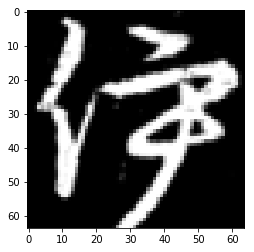

In [68]:
test_loader = DataLoader(validation_data, batch_size=batchsize, shuffle=True, num_workers=4)
images, labels =  iter(test_loader).next()

plt.imshow(images[0].view(64,64).numpy() * 0.5 + 0.5, cmap='gray')
for index, label in enumerate(labels[0]):
    if label == 1:
        print(radical_list[index])

In [72]:
outputs = net(images).cpu()
for index, output in enumerate(outputs[0]):
    if output == 1:
        print(radical_list[index])

ERROR! Session/line number was not unique in database. History logging moved to new session 236


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:201